# Volume 4: Inverted Pendulum
    Daniel Perkins
    MATH 439
    2/4/25

In [4]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from numpy.linalg import eig


# Problem 1

Write a function that returns the matrices A, B, Q, and R given above. Let
g = 9.8 m/s
2
.

In [5]:
def linearized_init(M, m, l, q1, q2, q3, q4, r):
      '''
      Parameters:
      ----------
      M, m: floats
            masses of the rickshaw and the present
      l   : float
            length of the rod
      q1, q2, q3, q4, r : floats
            relative weights of the position and velocity of the rickshaw, the
            angular displacement theta and the change in theta, and the control


      Return
      -------
      A : ndarray of shape (4,4)
      B : ndarray of shape (4,1)
      Q : ndarray of shape (4,4)
      R : ndarray of shape (1,1)
      '''
      # Set g
      g = 9.8
      
      # Make A
      A = np.zeros((4, 4))
      A[0, 1], A[2, 3] = 1, 1
      A[1, 2] = (m*g)/M
      A[3, 2] = (g/(M*l))*(M+m)
      
      # Make B
      B = np.zeros(4)
      B[1], B[3] = 1/M, 1/(M*l)
      
      # Make Q
      Q = np.zeros((4, 4))
      for i, q in enumerate([q1, q2, q3, q4]): Q[i,i]=q
      
      # Make R
      R = np.array([[r]])
      
      return A, B.reshape((4, 1)), Q, R

# Problem 2

Write the following function to find the matrix $P$ using `scipy.optimize.root`.
Since root takes in a vector and not a matrix, you will have to reshape the matrix P before
passing it in and after getting your result, using `np.reshape(16)` and `np.reshape((4,4))`.

In [6]:
def find_P(A, B, Q, R):
    '''
    Parameters:
    ----------
    A, Q : ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)
    
    Returns
    -------
    P : the matrix solution of the Riccati equation
    '''
    def f(P):
        P = P.reshape((4, 4))  # Reshape it to get a matrix
        sum = P@A
        sum += A.T@P
        sum += Q
        sum -= (P @ B @ (1/R)) @ B.T @ P
        return sum.flatten()
    
    # Initial guess to find solution
    initial_guess = np.ones(16)*.1
    sol = root(f, initial_guess).x
    P = sol.reshape((4, 4))
    
    return P

In [7]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
rs = [5.,10.]

# Find P
for r in rs:
    print(f"R={r}")
    A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)
    P = find_P(A, B, Q, R)
    print("P:\n", P)

    # Compute the eigenvalues of A
    left = A - B @ (1/R) @ B.T @ P
    eigenvalues, eigenvectors = eig(left)
    print("eigenvalues:\n", eigenvalues)
    print()

print("It appears that 3 of the four eigenvalues are negative (if we have r=5) and only 2 are negative with r=10")
print("This means that for this P, it is possible that the solution does not converge to 0")
print("Note: I printed the values for two values of r because I was not sure which one was needed.")

R=5.0
P:
 [[   3.31318527   27.71070258   -2.17095788  -19.85960605]
 [  27.69900243  469.44071558  -16.66743876 -335.2588233 ]
 [  -2.17029374  -16.67590375 -274.23847645   11.73566339]
 [ -19.85123379 -335.25932002   11.73118012  331.85700635]]
eigenvalues:
 [-1.72812265+0.j         -0.05988189+0.05894939j -0.05988189-0.05894939j
  1.7259385 +0.j        ]

R=10.0
P:
 [[ 2.10451491e-04 -3.79877901e-01 -4.97349576e-03  2.33875398e-01]
 [-3.81746570e-01 -5.82828316e+00  9.60014881e-02  4.16519313e+00]
 [-4.97292967e-03  9.46668094e-02 -4.60893512e+00 -2.51956890e-01]
 [ 2.35210083e-01  4.16519121e+00 -2.73599358e-01 -1.42997386e+00]]
eigenvalues:
 [-1.72703503  1.72701667 -0.0067195   0.00746282]

It appears that 3 of the four eigenvalues are negative (if we have r=5) and only 2 are negative with r=10
This means that for this P, it is possible that the solution does not converge to 0
Note: I printed the values for two values of r because I was not sure which one was needed.


# Problem 3
 
Write the following function that implements the LQR solution described earlier.
Use `scipy.integrate.solve_ivp` to solve the IVP.

In [8]:
def rickshaw(tv, X0, A, B, Q, R, P):
    '''
    Parameters:
    ----------
    tv : tuple containing start and stop times (t0,tf) that can be passed into solve_ivp
    X0 : Initial conditions on state variables
    A, Q: ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)
    P : ndarray of shape (4,4)
    Returns
    -------
    Z : ndarray of shape (n+1,4), the state vector at each time
    U : ndarray of shape (n+1,), the control values
    '''
    def ode(x, z):  # Equation 23.11
        out = (A - B @ (1/R) @ B.T @ P) @ z  
        return out
    
    t_eval = np.linspace(tv[0], tv[1], 200)  # 200 time steps
    
    # Solve the IVP
    Z = solve_ivp(ode, tv, X0, t_eval=t_eval).y
    
    # Calculate the optimal control
    U = (-(1/R) @ B.T @ P) @ Z
    
    return Z, U

# Problem 4

Test the function made in Problem (3). Find the matrix $P$ using the `scipy.optimize.root` method and plot with `tf=6` as well as the `solve_continuous_are`
method and plot with `tf=60`. Plot the solutions $\tilde{z}$ and $\tilde{u}$. Compare your results to Figure
21.3.

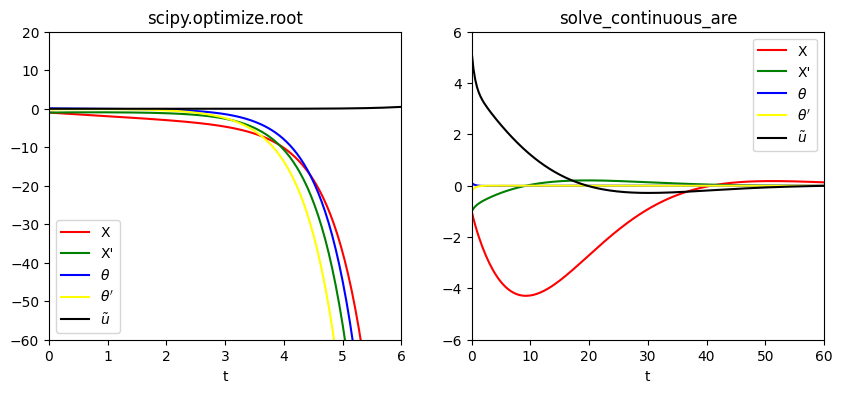

In [9]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.
tf = None
X0 = np.array([-1, -1, .1, -.2])

# Get A, B, Q, and R
A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)

# Find P with tf=6 now
tf1 = 6
ts1 = np.linspace(0, tf1, 200)
P1 = find_P(A, B, Q, R)

# Find P with solve_continuous_are method and tf=60
tf2 = 60
ts2 = np.linspace(0, tf2, 200)
P2 = solve_continuous_are(A, B, Q, R)

# Solve it
Z1, U1 = rickshaw((0, tf1), X0, A, B, Q, R, P1)
Z2, U2 = rickshaw((0, tf2), X0, A, B, Q, R, P2)

# Plot it
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("scipy.optimize.root")
plt.xlabel("t")
plt.plot(ts1, Z1[0], color="red", label="X")
plt.plot(ts1, Z1[1], color="green", label="X'")
plt.plot(ts1, Z1[2], color="blue", label=r"$\theta$")
plt.plot(ts1, Z1[3], color="yellow", label=r"$\theta'$")
plt.plot(ts1, U1[0], color="black", label=r"$\tilde{u}$")
plt.xlim(0, 6)
plt.ylim(-60, 20)
plt.legend()

plt.subplot(122)
plt.title("solve_continuous_are")
plt.xlabel("t")
plt.plot(ts2, Z2[0], color="red", label="X")
plt.plot(ts2, Z2[1], color="green", label="X'")
plt.plot(ts2, Z2[2], color="blue", label=r"$\theta$")
plt.plot(ts2, Z2[3], color="yellow", label=r"$\theta'$")
plt.plot(ts2, U2[0], color="black", label=r"$\tilde{u}$")
plt.xlim(0, 60)
plt.ylim(-6, 6)
plt.legend()
plt.show()


# Problem 5
Use the control $\tilde{u}$ that you found in problem 4 to solve the nonlinear equation

$\ddot x = \frac{u+m\sin\theta(-l\dot \theta^2+g\cos\theta)}{M+m(1-\cos^2\theta)}$,


$\ddot{\theta} = \frac{g(m+M)\sin\theta+\cos\theta(u-lm\dot\theta^2\sin\theta)}{l(M+m(1-\cos^2\theta))}$.

In [10]:
def nonlinear_ode(t, y, *params):
    '''
    Given y = (x, x', θ, θ'), return y' = (x', x'', θ', θ'').

    Use args=(u, G, M, m, l) in your call to solve_ivp,
    where u is your cubic spline interpolation of the control.

    y[0] -- x
    y[1] -- x prime
    y[2] -- theta
    y[3] -- theta prime
    '''
    x, xp, θ, θp = y

    u, G, M, m, l = params

    denom = M + m*(1 - np.cos(θ)**2)
    return np.array([
        xp,
        (u(t) + m * np.sin(θ) * (- l * θp**2 + G * np.cos(θ))) / denom,
        θp,
        (G * (m + M) * np.sin(θ) + np.cos(θ) * (u(t) - l * m * θp**2 * np.sin(θ))) / (l * denom)
    ])

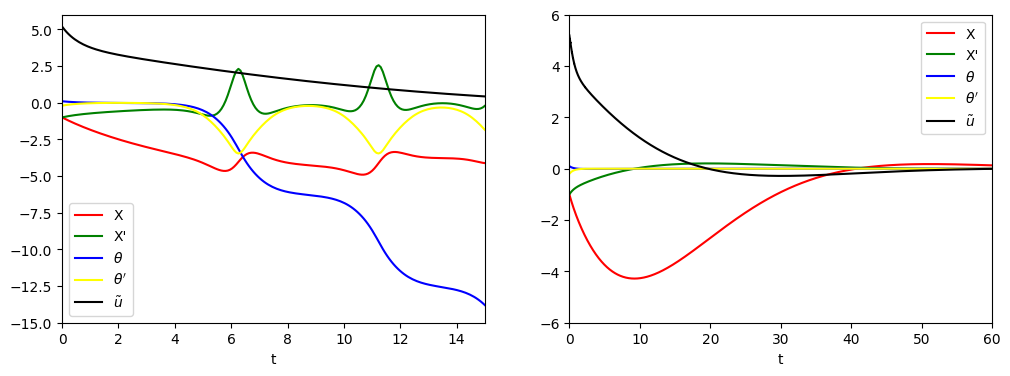

In [57]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.
tf = 15
X0 = np.array([-1, -1, .1, -.2])
ts = np.linspace(0, tf, 200)
G = 9.8

# Get A, B, Q, R, and P
A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)
P = solve_continuous_are(A, B, Q, R)

# Solve it using rickshaw
Z, U = rickshaw((0, tf), X0, A, B, Q, R, P)
x, x_prime, theta, theta_prime, u = Z[0], Z[1], Z[2], Z[3], U[0]
# Get cubic approximation
spline = CubicSpline(ts, u)

# Solve the nonlinear ODE
solution = solve_ivp(nonlinear_ode, (0, tf), X0, t_eval=ts, args=(spline, G, M, m, l))
x, x_prime, theta, theta_prime = solution.y

all_x = []
all_x_prime = []
all_theta = []
all_theta_prime = []
all_u = []
all_t = []

all_ts = np.geomspace(1, 61, 120)-1
for i in range(len(all_ts) - 1):
    new_t0, new_tf = all_ts[i], all_ts[i+1]
    Z, U = rickshaw((new_t0, new_tf), X0, A, B, Q, R, P)
    new_ts = np.linspace(new_t0, new_tf, 200)
    spline = CubicSpline(new_ts, U[0])
    solution = solve_ivp(nonlinear_ode, (new_t0, new_tf), X0, t_eval=new_ts, args=(spline, G, M, m, l))
    X0 = solution.y[:,-1]  # Define new initial value
    
    # Store the values
    all_t.append(new_ts)
    all_x.append(solution.y[0])
    all_x_prime.append(solution.y[1])
    all_theta.append(solution.y[2])
    all_theta_prime.append(solution.y[3])
    all_u.append(U[0])
    
# Convert the data to numpy arrays
all_t = np.concatenate(all_t)
all_x = np.concatenate(all_x)
all_x_prime = np.concatenate(all_x_prime)
all_theta = np.concatenate(all_theta)
all_theta_prime = np.concatenate(all_theta_prime)
all_u = np.concatenate(all_u)

# Plot first figure
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xlabel("t")
plt.plot(ts, x, color="red", label="X")
plt.plot(ts, x_prime, color="green", label="X'")
plt.plot(ts, theta, color="blue", label=r"$\theta$")
plt.plot(ts, theta_prime, color="yellow", label=r"$\theta'$")
plt.plot(ts, u, color="black", label=r"$\tilde{u}$")
plt.xlim(0, tf)
plt.ylim(-15, 6)
plt.legend()

# Plot first figure
plt.subplot(122)
plt.xlabel("t")
plt.plot(all_t, all_x, label="X", color="red")
plt.plot(all_t, all_x_prime, label="X'", color="green")
plt.plot(all_t, all_theta, label=r"$\theta$", color="blue")
plt.plot(all_t, all_theta_prime, label=r"$\theta'$", color="yellow")
plt.plot(all_t, all_u, label=r"$\tilde{u}$", color="black")
plt.xlim(0, 60)
plt.ylim(-6, 6)
plt.legend()
plt.show()
